In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Jun 13

@author: yaning
"""

import pickle
import torch
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import linregress

In [2]:
class Params:
    def __init__(self):
        self.u_se_ampa = 0.5
        self.u_se_nmda = 0.5
        self.u_se_gaba = 0.5
        self.tau_rec_ampa = 5.0
        self.tau_rec_nmda = 12.0
        self.tau_rec_gaba = 12.0
        # self.tau_rec_gaba = 3.0
        self.tau_rise_ampa = 15.0
        # self.tau_rise_ampa = 50.0
        self.tau_rise_nmda = 150.0
        self.tau_rise_gaba = 15.0
        self.learning_rate = 1.0
        self.weight_scale = 1.0

params = Params()

In [38]:
def check_fire_lower(mp):
    activeness = (mp > 20).float()
    return activeness

In [68]:


path = "/home/yaning/Documents/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# with open(path + "fire_data_mnst_two.pkl", "rb") as f:
with open(path + "Spiking_add_files/fire_data_mnst_nine.pkl", "rb") as f:
    fire_data = pickle.load(f)

train = False
keep_learning = False
train_file = "train_multi_E20_zipper.pkl"

fire_data = torch.tensor(fire_data, device=device).float()
# fire_data = fire_data[5]
one_pic = fire_data

In [69]:



# parameters
gMax_Na = 120
rE_Na = 115

gMax_K = 36
rE_K = -12

gMax_leaky = 0.3
rE_leaky = 10.6

deltaTms = 0.05
Cm = 1
pointCount = fire_data.shape[-1]

# siemens unit n_s
# gMax_AMPA = 0.00072
# gMax_NMDA = 0.0012
# gMax_GABA = 0.0004

gMax_AMPA = 0.00072 
gMax_NMDA = 0.0012
gMax_GABA = 0.004
# gMax_GABA = 0.006

# # below are from the book
# gMax_AMPA = 0.72
# gMax_NMDA = 1.2
# gMax_GABA = 0.04

rE_AMPA = 70
rE_NMDA = 70
rE_GABA = 0

mg = 0.01
# mg = 1.2

threshold = -50 + 70
current_threshold = -200


# # guesses
# u_se = torch.tensor([0.9, 0.9, 0.9], device=device)
# tau_rec = torch.tensor([5, 12, 12], device=device)
# guesses
u_se = torch.tensor([params.u_se_ampa, params.u_se_nmda, params.u_se_gaba], device=device)
tau_rec = torch.tensor([params.tau_rec_ampa, params.tau_rec_nmda, params.tau_rec_gaba], device=device)
# tau_rec = tau_rec

# below from paper 
tau_pre = torch.tensor([20, 20, 20], device=device)
# tau_pre = tau_pre
tau_decay = torch.tensor([2.4, 100, 7], device=device)
# tau_decay = tau_decay

# rise has to be quicker than decay, tau needs to be bigger (negative deri)
# tau_rise = torch.tensor([1, 50, 3], device=device)
tau_rise = torch.tensor([params.tau_rise_ampa, params.tau_rise_nmda, params.tau_rise_gaba], device=device)
# tau_rise = tau_rise
# guesses
# learning_rate = 100
# weight_scale = 10

learning_rate = params.learning_rate
weight_scale = params.weight_scale


# generate the exponential decrease with time gap values
gaps = torch.arange(400, 0, -1, device=device).unsqueeze(0).expand(3,400)
temp_tau_pre = tau_pre.unsqueeze(-1)
weight_values_matrix = torch.exp(-gaps/temp_tau_pre)

for _ in range(5):
    weight_values_matrix = weight_values_matrix.unsqueeze(1)


def update_states(mp, current_states, deltaTms=0.05):
        m_alpha = .1*((25-mp) / (torch.exp((25-mp)/10)-1))
        m_beta = 4*torch.exp(-mp/18)
        n_alpha = .01 * ((10-mp) / (torch.exp((10-mp)/10)-1))
        n_beta = .125*torch.exp(-mp/80)
        h_alpha = .07*torch.exp(-mp/20)
        h_beta = 1/(torch.exp((30-mp)/10)+1)

        alphas = torch.stack([m_alpha, n_alpha, h_alpha], dim=0)
        betas = torch.stack([m_beta, n_beta, h_beta], dim=0)

        alpha_states = alphas*(1-current_states)
        beta_states = betas*current_states

        new_states = current_states + deltaTms*(alpha_states - beta_states)

        return new_states

def broadcast_params(param, target):
    # param = param[:,None]*torch.ones_like(target)[None,...]
    new_shape = (3,) + (1,)*(target.dim()-1)
    param = param.view(new_shape)
    param = param.expand_as(target)
    return param

def broadcast_mp(mp, connection_matrix):
    num_missing_dim = connection_matrix.dim() - mp.dim()
    mp = mp.view(*([1]*num_missing_dim), *mp.shape)
    mp = mp.expand_as(connection_matrix)
    return mp


def runge_kutta(f, y0, h, *arg):
    k1 = f(y0, *arg)
    k2 = f(y0 + h*k1/2, *arg)
    k3 = f(y0 + h*k2/2, *arg)
    k4 = f(y0 + h*k3, *arg)

    next = y0 + h/6*(k1 + 2*k2 + 2*k3 + k4)

    return next

# # deri as deriviation 
# def e_deri(e, on_off):
#     return (1-e)/tau_rec[None,:,None,None] - u_se[None,:,None,None]*on_off

# def g_decay_deri(g_decay, w, e, on_off):
#     return -g_decay/tau_decay[None,:,None,None] + w*e*on_off

# def g_rise_deri(g_rise, w, e, on_off):
#     return -g_rise/tau_rise[None,:,None,None] + w*e*on_off

# deri as deriviation 
def e_deri(e, on_off):
    tau_rec_broad = broadcast_params(tau_rec, e)
    u_se_broad = broadcast_params(u_se, e)
    return (1-e)/tau_rec_broad - u_se_broad*on_off*e

def g_decay_deri(g_decay, w, e, on_off):
    tau_decay_broad = broadcast_params(tau_decay, e)
    return -g_decay/tau_decay_broad + w*e*on_off

def g_rise_deri(g_rise, w, e, on_off):
    tau_rise_broad = broadcast_params(tau_rise, e)
    return -g_rise/tau_rise_broad + w*e*on_off

def update_gPs(es, ws, g_decays, g_rises, fires, recurrent, deltaTms=0.05):
    # cycle is how many layers it connects 
    cycle = len(es)
    new_es = []
    new_g_decays = []
    new_g_rises = []
    gPs = []
    
    for i in range(cycle):

        fire = fires[i]
        fire = fire.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
        fire = fire.expand(*es[i].shape)

        if recurrent and i == 0:
            e = es[i]
            e.fill_(1)
        else:
            e = runge_kutta(e_deri, es[i], deltaTms, fire)
        if (e < 0).any():
            print("e negative")
            e[e < 0] = 0


        # deltaTms * 10 is not good, when try to find the right params need to delete this
        g_decay = runge_kutta(g_decay_deri, g_decays[i], deltaTms, ws[i], e, fire)
        g_rise = runge_kutta(g_rise_deri, g_rises[i], deltaTms, ws[i], e, fire)


        gP = g_rise - g_decay
        if (gP < 0).any():
            print("gP negative")
            gP[gP < 0] = 0
            
        new_es.append(e)
        new_g_decays.append(g_decay)
        new_g_rises.append(g_rise)
        gPs.append(gP)

    return new_es, new_g_decays, new_g_rises, gPs


def initialise(*args):
    d = args[0]

    # cells, states, mp are fine with only individual cells
    cells = torch.zeros((d, d), device=device)

    m_states = cells.clone()
    m_states.fill_(0.061956531255774015)

    n_states = cells.clone()
    n_states.fill_(0.3384883478113268)

    h_states = cells.clone()
    h_states.fill_(0.5484107720738856)

    states = torch.stack([m_states, n_states, h_states], dim=0)

    mp = cells.clone()
    mp.fill_(1.3458754117369027)

    # the synapses properties are not individual cell but 
    # shape as the connections

    es = []
    ws = []
    g_decays = []
    g_rises = []

    # if randomize:
    for arg in args[1:]:
        gaussian = arg[1]
        weight = arg[2]
        arg = arg[0]

        muster = torch.zeros(arg.shape, device=device)

        e = muster.clone()
        e.fill_(1)
        es.append(e)

        #---------------------about weight---------------------------------------
        if not gaussian:
            w = torch.rand(*arg.shape[1:], device=device)*weight
        else:
            w = torch.ones(*arg.shape[1:], device=device)*weight

        shape = [3] + [1]*w.ndim
        w = w.unsqueeze(0).repeat(shape)
        # w = torch.rand(*arg.shape, device=device)*weight_scale

        w = w*arg


        ws.append(w)


        #-----------------------------------------------------------------------

        g_decay = muster.clone()
        g_decay.fill_(1)
        g_decay = g_decay*arg
        g_decays.append(g_decay)

        g_rise = muster.clone()
        g_rise.fill_(1)
        g_rise = g_rise*arg
        g_rises.append(g_rise)


    # normalise ws
    



    return cells, states, mp, es, ws, g_decays, g_rises

def check_fire(mp):
    activeness = (mp > threshold).float()
    return activeness


def update_I_E(mp, gPs, states):

    # generate currents based on gPs
    cycle = len(gPs)
    muster = torch.zeros_like(mp)
    AMPA_currents = muster.clone()
    NMDA_currents = muster.clone()
    GABA_currents = muster.clone()
    
    for i in range(cycle):
        temp_mp = broadcast_mp(mp, gPs[i])

        AMPA_currents += (gMax_AMPA*gPs[i][0,...]*(temp_mp-rE_AMPA)).sum(dim=tuple(range(temp_mp.ndim - 2)))
        NMDA_currents += (gMax_NMDA*gPs[i][1,...]*(1/(1+mg*torch.exp(-0.062*temp_mp)/3.57))*(temp_mp-rE_NMDA)).sum(dim=tuple(range(temp_mp.ndim - 2)))
        GABA_currents += (gMax_GABA*gPs[i][2,...]*(temp_mp-rE_GABA)*(-1)).sum(dim=tuple(range(temp_mp.ndim - 2)))



    Ireceptors = AMPA_currents + NMDA_currents + GABA_currents

    # Ireceptors[Ireceptors >= 0] = 0.0


    overflow_neurons = (Ireceptors <= current_threshold).float()

    
    sodium_currents = gMax_Na*torch.pow(states[0], 3) * states[2]*(mp-rE_Na)
    potassium_currents = gMax_K*torch.pow(states[1], 4)*(mp-rE_K)
    leaky_currents = gMax_leaky*(mp-rE_leaky)

    total_I = - sodium_currents - potassium_currents - leaky_currents - Ireceptors


    mp = mp + deltaTms*total_I/Cm
    # mp = torch.clamp(mp, max=50.0)

    return mp


# initialise everything

pixel_num = 10
feature_num = 8
E_num = 20
I_num = 4
Out_num = 5


#-----------connection matrices-------------
# ampa
In_con_E = torch.zeros(3, pixel_num, pixel_num, feature_num, E_num, E_num, device=device)
# all-to-all  connections
In_con_E[0].fill_(1.)

# the later two E_nums are the one sending out the connections/the center
# ampa and nmda
E_con_E = torch.zeros(E_num, E_num, E_num, E_num, device=device)
sigma_E_E = 2
max_E_E = 4.5
for i in range(E_num):
    for j in range(E_num):
        for k in range(E_num):
            for l in range(E_num):
                project_center_x = k
                project_center_y = l

                # dx = min(abs(project_center_x - i), E_num-abs(project_center_x - i))
                # dy = min(abs(project_center_y - j), E_num-abs(project_center_y - j))
                
                dx = abs(project_center_x - i)
                dy = abs(project_center_y - j)

                euc_distance = math.sqrt(dx**2 + dy**2)
                

                # euc_distance = math.sqrt((project_center_x - i)**2 + (project_center_y - j)**2)
                E_con_E[i,j,k,l] = max_E_E*math.exp(-0.5*(euc_distance/sigma_E_E)**2)
E_con_E = E_con_E.permute(2, 3, 0, 1)
E_con_E = E_con_E.unsqueeze(0).repeat(3,1,1,1,1)
E_con_E[-1] = 0


# E to I connection matrix (p=0.1)
# ampa and nmda 
E_con_I = torch.zeros(E_num, E_num, I_num, I_num, device=device)
num_elements = E_con_I.numel()
num_ones = max(1, int(num_elements * 0.1))  # Ensure at least 1 element
flat_indices = torch.randperm(num_elements)[:num_ones]
E_con_I.view(-1)[flat_indices] = 1
E_con_I = E_con_I.unsqueeze(0).repeat(3,1,1,1,1)
E_con_I[-1] = 0

# I to E connection matrix (p=0.024)
# gaba
I_con_E = torch.zeros(I_num, I_num, E_num, E_num, device=device)
num_elements = I_con_E.numel()
num_ones = max(1, int(num_elements * 0.024))  # Ensure at least 1 element
flat_indices = torch.randperm(num_elements)[:num_ones]
I_con_E.view(-1)[flat_indices] = 1
I_con_E = I_con_E.unsqueeze(0).repeat(3,1,1,1,1)
I_con_E[0] = 0
I_con_E[1] = 0

# I to I self connection (p=0.1)
# gaba
I_con_I = torch.zeros(I_num, I_num, I_num, I_num, device=device)
num_elements = I_con_I.numel()
num_ones = max(1, int(num_elements * 0.1))  # Ensure at least 1 element
flat_indices = torch.randperm(num_elements)[:num_ones]
I_con_I.view(-1)[flat_indices] = 1
I_con_I = I_con_I.unsqueeze(0).repeat(3,1,1,1,1)
I_con_I[0] = 0
I_con_I[1] = 0

# E to Out connection
# ampa
E_con_Out = torch.zeros(E_num, E_num, Out_num, Out_num, device=device)
sigma_E_Out = 2
max_E_Out = 1
# find the center point from Output to E
ratio = E_num/Out_num
for i in range(E_num):
    for j in range(E_num):
        for k in range(Out_num):
            for l in range(Out_num):
                project_center_x = k*ratio
                project_center_y = l*ratio

                euc_distance = math.sqrt((project_center_x - i)**2 + (project_center_y - j)**2)
                E_con_Out[i,j,k,l] = max_E_Out*math.exp(-0.5*(euc_distance/sigma_E_Out)**2)
E_con_Out = E_con_Out.unsqueeze(0).repeat(3,1,1,1,1)
E_con_Out[1] = 0
E_con_Out[2] = 0


#----------E---------------------
E_cells, E_states, E_mp, E_es, E_ws, E_g_decays, E_g_rises = initialise(E_num, 
                                                                        [In_con_E, False, weight_scale], 
                                                                        [E_con_E, True, weight_scale], 
                                                                        [I_con_E, False, weight_scale*16])
# E_ws = normalise_weight(E_ws)
# this normalise step is not very necessary but meh 
sums = E_ws[0][0].sum(dim=(0,1,2), keepdim=True)   # sum over presyn dims for each post neuron
E_ws[0][0] = E_ws[0][0]/sums*learning_rate*10


#----------I-----------------
I_cells, I_states, I_mp, I_es, I_ws, I_g_decays, I_g_rises = initialise(I_num, 
                                                                        [E_con_I, False, weight_scale], 
                                                                        [I_con_I, False, weight_scale])
# I_ws = normalise_weight(I_ws)


#-----------Output-------------
Out_cells, Out_states, Out_mp, Out_es, Out_ws, Out_g_decays, Out_g_rises = initialise(Out_num, 
                                                                                        [E_con_Out, True, weight_scale])
# Out_ws = normalise_weight(Out_ws)

# # ------------------set to a good learning state-----------------------------------------
# if train and not keep_learning:
#     with open(path + "/Spiking_NN/datasets/SNN_states/pretty_good_states.pkl", "rb") as f:
#         test_states = pickle.load(f)
    
#     # I_ws = test_states["initial_I_ws"]
#     E_ws = test_states["initial_E_ws"]

#-------------------keep learning----------------------------------------------------------
if train and keep_learning:
    with open(path + "/Spiking_NN/datasets/SNN_states/" + train_file, "rb") as f:
        last_states = pickle.load(f)
    
    # I_ws = test_states["initial_I_ws"]
    E_ws = last_states["E_ws"]

if train:
    states = {}
    initial_E_ws = []
    for i in E_ws:
        initial_E_ws.append(i.detach().clone())
    states["initial_E_ws"] = initial_E_ws

    initial_I_ws = []
    for i in I_ws:
        initial_I_ws.append(i.detach().clone())
    states["initial_I_ws"] = initial_I_ws

    initial_Out_ws = []
    for i in Out_ws:
        initial_Out_ws.append(i.detach().clone())
    states["initial_Out_ws"] = initial_Out_ws
# -----------------------------------------run-------------------------------------------------


if not train:
    # # use last weights
    with open(path + "Spiking_add_files/" + train_file, "rb") as f:
    # with open(path + "fire_data_gabor_binary.pkl", "rb") as f:
        states = pickle.load(f)
    # E_ws[0][0] = states["E_ws"][0][0]
    E_ws = states["E_ws"]
    # I_ws = states["I_ws"]
    # Out_ws = states["Out_ws"]



dims = list(range(one_pic.ndim))
new_order = [dims[-1]] + dims[:-1]
In_fires = one_pic.permute(new_order)
E_fires = torch.zeros((pointCount, E_num, E_num), device=device)
I_fires = torch.zeros((pointCount, I_num, I_num), device=device)
Out_fires = torch.zeros((pointCount, Out_num, Out_num), device=device)


for t in range(pointCount):
    if t % 1000 == 0:  # every 50 steps
        print(f"Progress: {t}/{pointCount} ({100*t/pointCount:.1f}%)")
    # check mp and which fires then change connected layer activeness
    # Input to E
    In_fire = one_pic[:, :, :, t]

    if E_mp.isnan().any():
        print("oops")
        print(t)
        data = {
            # 'In_fires': In_fires*100,
            'In_fires': In_fires,
            'E_fires': E_fires,
            'I_fires': I_fires,
            'Out_fires': Out_fires
        }

        # with open(path + 'large_files/fires_new.pkl', 'wb') as f:
        #     pickle.dump(data, f)
        


    # add spontaneous firing
    # mask = torch.rand(E_mp.shape) < 0.001
    # E_mp[mask] = spontaneous_mp
    E_fire = check_fire(E_mp)
    E_fire_lower = check_fire_lower(E_mp)
    E_fires[t] = E_fire_lower
    # E_fires[t] = E_fire
    # E_fires[t] = E_mp


    # mask = torch.rand(I_mp.shape) < 0.001
    # I_mp[mask] = spontaneous_mp
    I_fire = check_fire(I_mp)
    I_fire_lower = check_fire_lower(I_mp)
    I_fires[t] = I_fire_lower
    # I_fires[t] = I_fire
    # I_fires[t] = I_mp
    
    # mask = torch.rand(Out_mp.shape) < 0.001
    # Out_mp[mask] = spontaneous_mp
    Out_fire = check_fire(Out_mp)
    Out_fire_lower = check_fire_lower(Out_mp)
    Out_fires[t] = Out_fire_lower
    # Out_fires[t] = Out_fire
    # Out_fires[t] = Out_mp


    # -----------------update gPs based on activeness--------------------------------
    # update them by each layer connection, cannot do it at the same time because
    # the shapes are different

    E_states = update_states(E_mp, E_states) 
    E_es, E_g_decays, E_g_rises, E_gPs = update_gPs(E_es, E_ws, E_g_decays, E_g_rises, [In_fire, E_fire, I_fire], 1)


    I_states = update_states(I_mp, I_states)
    I_es, I_g_decays, I_g_rises, I_gPs = update_gPs(I_es, I_ws, I_g_decays, I_g_rises, [E_fire, I_fire], 0)


    Out_states = update_states(Out_mp, Out_states)
    Out_es, Out_g_decays, Out_g_rises, Out_gPs = update_gPs(Out_es, Out_ws, Out_g_decays, Out_g_rises, [E_fire], 0)



    # ------------------generate currents and voltages based on gPs-------------------------------

    E_mp = update_I_E(E_mp, E_gPs, E_states)
    # E_mp, E_ws = update_I_E(E_gPs, E_mp, E_states, E_ws)
    

    I_mp = update_I_E(I_mp, I_gPs, I_states)
    # I_mp, I_ws = update_I_E(I_gPs, I_mp, I_states, I_ws)

    Out_mp = update_I_E(Out_mp, Out_gPs, Out_states)
    # Out_mp, Out_ws = update_I_E(Out_gPs, Out_mp, Out_states, Out_ws)

    
    # -------------------------update weights----------------------------------
    # only In to E
    # get the matrix of needed to change weight from the cons (Q: including the current time step?)
    # take only the 400 time step before, equals to 20ms, which is the learning period in the paper
    # for now update after 400 time steps 
    if train:
        if t >= 400:
            past_pre_fires = In_fires[t-399:t+1,:,:,:]
            # using just multiplication
            interactions = torch.einsum('tijk,ab->ijkabt', past_pre_fires, E_fire)
            dw = (interactions*weight_values_matrix).sum(dim=-1)[0]
            E_ws[0][0] += dw #*(1/(1+0.07*(t-400)))

    # # only normalise the In to E connection's AMPA connection hence the [0][0]
    # # E_ws[0][0] = E_ws[0][0]/E_ws[0][0].sum(dim=(0,1,2), keepdim=True)*weight_scale*5
    sums = E_ws[0][0].sum(dim=(0,1,2), keepdim=True)   # sum over presyn dims for each post neuron
    # # E_ws[0][0] = E_ws[0][0] / sums * (weight_scale * 5 / (E_ws[0][0].shape[2]*E_ws[0][0].shape[3])) #----this step looks weird
    E_ws[0][0] = E_ws[0][0]/sums*learning_rate*10



    # voltages.append(E_mp[10,10].cpu()-70)

data = {
    # 'In_fires': In_fires*100,
    'In_fires': In_fires,
    'E_fires': E_fires,
    'I_fires': I_fires,
    'Out_fires': Out_fires
}

# skip showing the silence part between 600 - 1500
# data = {
#     'In_fires': torch.cat([In_fires[:600]*100,In_fires[1501:2500]*100, In_fires[3200:]], dim=0),
#     'E_fires': torch.cat([E_fires[:600], E_fires[1501:2500], E_fires[3200:]], dim=0),
#     'I_fires': torch.cat([I_fires[:600], I_fires[1501:2500], I_fires[3200:]], dim=0),
#     'Out_fires': torch.cat([Out_fires[:600], Out_fires[1501:2500], Out_fires[3200:]], dim=0)
# }

# data = {
#     'In_fires': In_fires[1600:]*100,
#     # 'In_fires': In_fires,
#     'E_fires': E_fires[1600:],
#     'I_fires': I_fires[1600:],
#     'Out_fires': Out_fires[1600:]
# }

if train:
    after_E_ws = []
    for i in E_ws:
        after_E_ws.append(i.detach().clone())
    states["E_ws"] = after_E_ws
    # states["E_ws"] = E_ws[0][0].detach().clone()
    
    # states = {
    #     "E_ws": E_ws
    #     # "I_ws": I_ws,
    #     # "Out_ws": Out_ws
    # }


    with open(path + 'Spiking_NN/datasets/SNN_states/' + train_file, 'wb') as f:
        pickle.dump(states, f)



Progress: 0/4000 (0.0%)
Progress: 1000/4000 (25.0%)
Progress: 2000/4000 (50.0%)
Progress: 3000/4000 (75.0%)


In [41]:
E_fires = E_fires.cpu()

Calculate the energy

In [42]:
len(E_ws)

3

In [70]:
E_fires_one = E_fires*2 -1

In [71]:
I_fires_one = I_fires*2 -1

In [62]:
for i in range(len(E_ws)):
    E_ws[i] = E_ws[i].cpu()

AttributeError: 'builtin_function_or_method' object has no attribute 'cpu'

In [76]:
E_fires_one[:,:,:,None,None].shape

torch.Size([4000, 20, 20, 1, 1])

In [77]:
I_fires_one[:,None,None:,:].shape

torch.Size([4000, 1, 4, 4])

In [93]:
E_ws[1].shape

torch.Size([3, 20, 20, 20, 20])

In [90]:
Energy_E_I_AMPA = -torch.sum(I_ws[0][0][None,...]*E_fires_one[:,:,:,None,None]*I_fires_one[:,None,None,:,:], dim=tuple(range(1, I_ws[0][0][None,...].ndim)))
Energy_E_I_NMDA = -torch.sum(I_ws[0][1][None,...]*E_fires_one[:,:,:,None,None]*I_fires_one[:,None,None,:,:], dim=tuple(range(1, I_ws[0][1][None,...].ndim)))

Energy_I_I_GABA = -torch.sum(-I_ws[1][2][None,...]*I_fires_one[:,:,:,None,None]*I_fires_one[:,None,None,:,:], dim=tuple(range(1, I_ws[1][2][None,...].ndim)))



In [94]:
Energy_I_E_GABA = -torch.sum(-E_ws[2][2][None,...]*I_fires_one[:,:,:,None,None]*E_fires_one[:,None,None,:,:], dim=tuple(range(1, E_ws[2][2][None,...].ndim)))
Energy_E_E_AMPA = -torch.sum(E_ws[1][0][None,...]*E_fires_one[:,:,:,None,None]*E_fires_one[:,None,None,:,:], dim=tuple(range(1, E_ws[1][0][None,...].ndim)))
Energy_E_E_NMDA = -torch.sum(E_ws[1][1][None,...]*E_fires_one[:,:,:,None,None]*E_fires_one[:,None,None,:,:], dim=tuple(range(1, E_ws[1][1][None,...].ndim)))

In [95]:
full_energy = Energy_E_I_AMPA + Energy_E_I_NMDA + Energy_I_I_GABA +Energy_I_E_GABA + Energy_E_E_AMPA + Energy_E_E_NMDA

In [82]:
Energy_E_I_AMPA.shape

torch.Size([4000])

In [25]:
I_fires.shape

torch.Size([4000, 4, 4])

In [26]:
E_fires.shape

torch.Size([4000, 20, 20])

In [7]:
times = torch.arange(0, 4000)

In [12]:
sum_two_zipper = E_fires.sum(dim=(1,2))

In [19]:
sum_six_zipper = E_fires.sum(dim=(1,2))

In [96]:
sum_nine_zipper = E_fires.sum(dim=(1,2))

In [118]:
sum_zero_zipper = E_fires.sum(dim=(1,2))

In [66]:
sum_zero_another_zipper = E_fires.sum(dim=(1,2))

In [8]:
sum_nine_another_zipper = E_fires.sum(dim=(1,2))

In [9]:
import numpy as np
from scipy.ndimage import label


def avalanches(fires):
    # Label connected components (blobs)
    labeled_array, num_features = label(fires, structure=np.ones((3,3)))

    # Compute size of each blob (avalanche size)
    blob_sizes = []
    for i in range(1, num_features+1):
        size = np.sum(labeled_array == i)
        blob_sizes.append(size)


    blob_sizes = np.array(blob_sizes)
    labeled_array = np.array(labeled_array)
    return blob_sizes, labeled_array
    # print("Avalanche sizes (number of ones per blob):", blob_sizes)



See the histogram avalanches size and total activities relationship

In [140]:
# per time
total_sizes_nine_another_zipper = []
labels_nine_another_zipper = []
for i in range(E_fires.shape[0]):
    blob_sizes, temp_label= avalanches(E_fires[i])

    # limit sizes
    # blob_sizes = blob_sizes[blob_sizes>5]
    # blob_sizes = blob_sizes[blob_sizes<10]

    total_sizes_nine_another_zipper.append(blob_sizes)
    labels_nine_another_zipper.append(temp_label)


In [141]:
critical_list = []
window_size = 20
for i in range(4000):
    regional = total_sizes_nine_another_zipper[max(0,i-window_size):min(len(total_sizes_nine_another_zipper),i+window_size)]
    flat = [item for sublist in regional for item in sublist]
    flat = np.array(flat)
    unique_sizes, counts = np.unique(flat, return_counts= True)
    # print(regional)

    if unique_sizes.shape[0] >1:
        
        # probs = counts/counts.sum()

        log_sizes = np.log(unique_sizes)
        log_probs = np.log(counts)

        res = linregress(log_sizes, log_probs)

        temp_slope = res.slope
    else:
        # print("zero")
        temp_slope = 0
    critical_list.append(temp_slope)

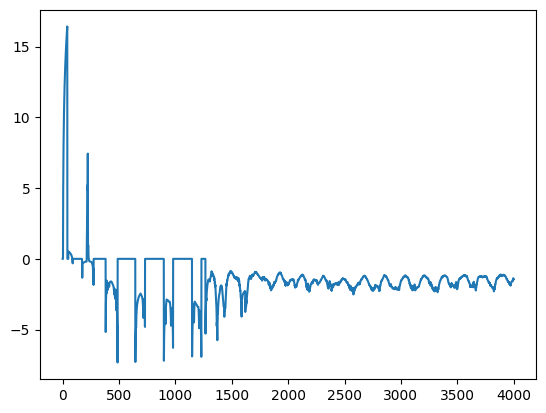

In [142]:
plt.plot(critical_list)

In [96]:
critical_list = np.array(critical_list)

In [97]:
np.isnan(critical_list).any()

np.True_

In [46]:
len(total_sizes_nine_another_zipper)

4000

In [45]:
length_sizes = []
for i in total_sizes_nine_another_zipper:
    length_sizes.append(i.shape[0])

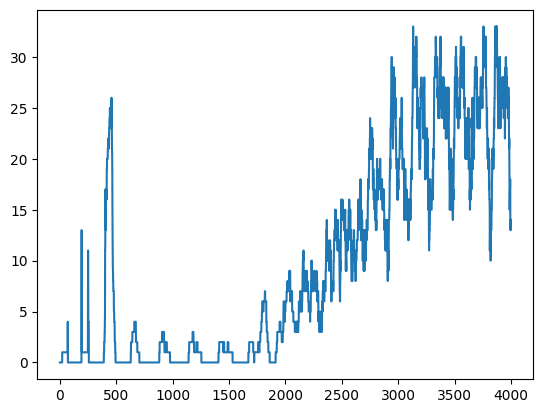

In [46]:
plt.plot(length_sizes)

In [10]:
time = []
value = []
for i in range(len(total_sizes_six_zipper)):
    for j in total_sizes_six_zipper[i]:
        time.append(i)
        value.append(j)


In [11]:
df_six_zipper = pd.DataFrame({
    "value": value,
    "time": time
})

In [15]:
ratio = sum_nine_zipper[:3000]/(torch.tensor(length_sizes[:3000])+1e-8)

In [123]:
np.argmax(ratio[500:])

tensor(806)

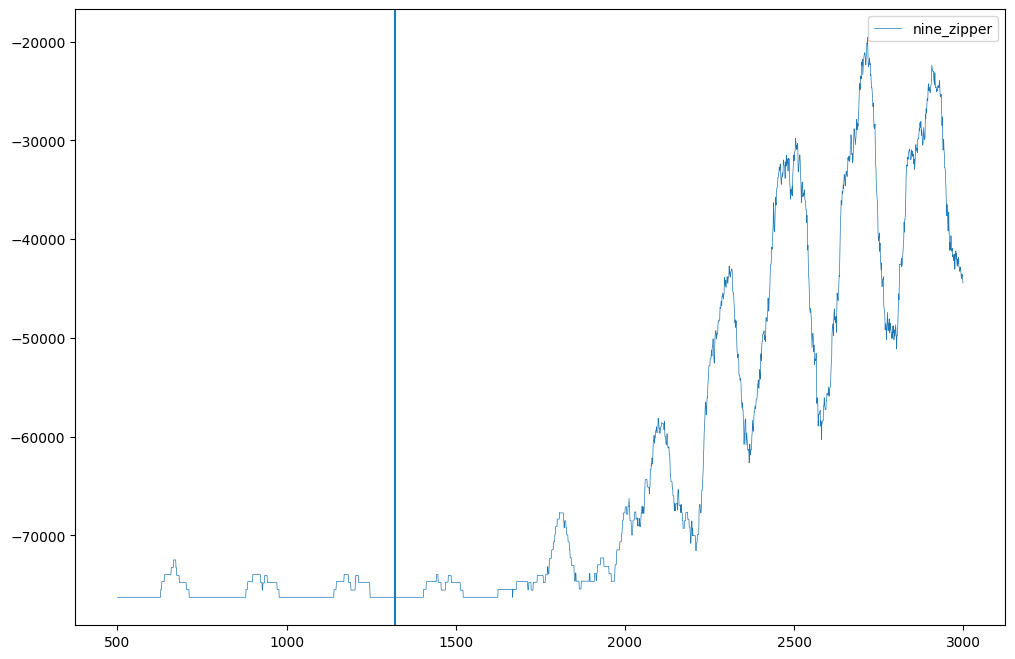

In [103]:
# df["time_num"] = pd.to_numeric(df["time"], errors="coerce")
fig, ax = plt.subplots(figsize=(12, 8))
# sns.scatterplot(data=df[:], x="time", y="value", ax=ax, s=5)
# ax.plot(times[500:], sum_six.cpu()[500:], label='six', lw=0.5)
# ax.plot(times[500:], sum_nine.cpu()[500:], label='nine', lw=0.5)
# ax.plot(times[500:], sum_zero.cpu()[500:], label='zero', lw=0.5)
# ax.plot(times[:3000], sum_two_zipper.cpu()[:3000], label='seven', lw=0.5)
# ax.plot(times[500:3000], sum_nine_zipper.cpu()[500:3000], label='nine_zipper', lw=0.5)
ax.plot(times[500:3000], full_energy.cpu()[500:3000], label='nine_zipper', lw=0.5)
# ax.plot(times[:3000], sum_six_zipper.cpu()[:3000], label='six_zipper', lw=0.5)
# ax.plot(times[:3000], sum_zero_zipper[:3000], label='nine_another', lw=0.5)
# ax.plot(times[:3000], length_sizes[:3000])
# ax.plot(times[:3000], sum_nine_zipper[:3000]/(np.array(length_sizes[:3000])+1e-8), label="ratio", lw=0.5)
# ax.plot(times[:3000], smooth_test[:3000], label='nine_another', lw=0.5)
# ax.plot(times[500:], critical_list[500:], label="smooth")
ax.axvline(x=1278+43)

# ax.set_ylim([-10,100])

ax.legend()

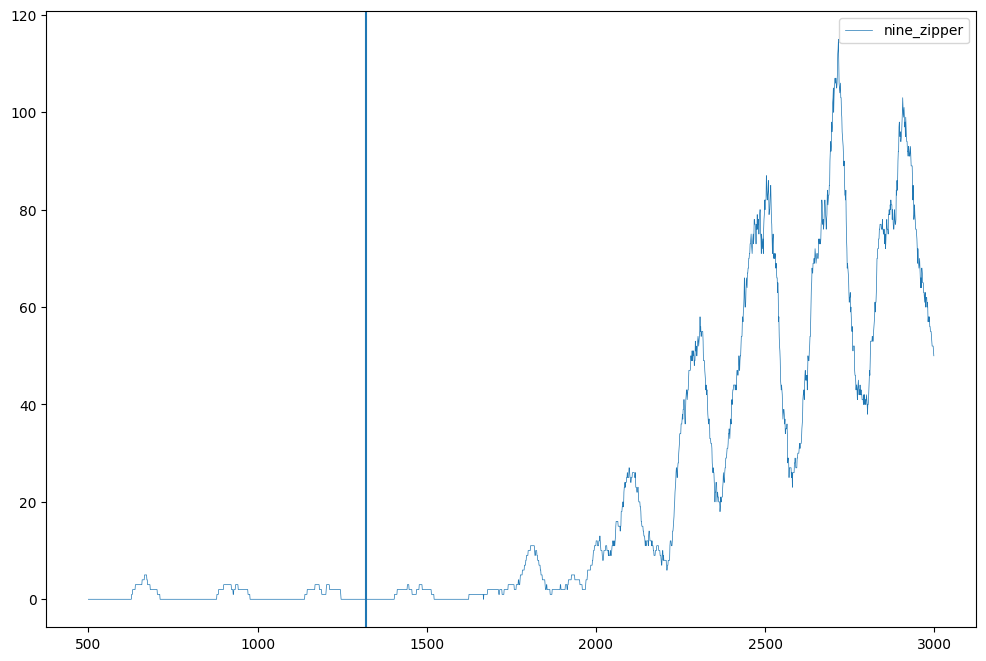

In [102]:
# df["time_num"] = pd.to_numeric(df["time"], errors="coerce")
fig, ax = plt.subplots(figsize=(12, 8))
# sns.scatterplot(data=df[:], x="time", y="value", ax=ax, s=5)
# ax.plot(times[500:], sum_six.cpu()[500:], label='six', lw=0.5)
# ax.plot(times[500:], sum_nine.cpu()[500:], label='nine', lw=0.5)
# ax.plot(times[500:], sum_zero.cpu()[500:], label='zero', lw=0.5)
# ax.plot(times[:3000], sum_two_zipper.cpu()[:3000], label='seven', lw=0.5)
ax.plot(times[500:3000], sum_nine_zipper.cpu()[500:3000], label='nine_zipper', lw=0.5)
# ax.plot(times[500:3000], full_energy.cpu()[500:3000], label='nine_zipper', lw=0.5)
# ax.plot(times[:3000], sum_six_zipper.cpu()[:3000], label='six_zipper', lw=0.5)
# ax.plot(times[:3000], sum_zero_zipper[:3000], label='nine_another', lw=0.5)
# ax.plot(times[:3000], length_sizes[:3000])
# ax.plot(times[:3000], sum_nine_zipper[:3000]/(np.array(length_sizes[:3000])+1e-8), label="ratio", lw=0.5)
# ax.plot(times[:3000], smooth_test[:3000], label='nine_another', lw=0.5)
# ax.plot(times[500:], critical_list[500:], label="smooth")
ax.axvline(x=1278+43)

# ax.set_ylim([-10,100])

ax.legend()

In [14]:
def smoothing(arr, window_size):
    temp = np.convolve(arr, np.ones(window_size)/window_size, mode='same')
    return temp

In [16]:
smooth_ratio = smoothing(ratio, 10)

In [15]:
smooth_test = smoothing(sum_nine_another_zipper, 10)

In [15]:
from scipy.signal import savgol_filter, find_peaks

smoothed = savgol_filter(sum_nine_zipper, window_length=101, polyorder=3)

# num_first_peak = find_first_peak(smoothed[num_last_zero:])
peaks, properties = find_peaks(
    smoothed[1278:],
    prominence=5,   
    distance=300
)

# y = your signal (1D array)

# 1. Smooth
# y_smooth = savgol_filter(ratio[500:], window_length=101, polyorder=3)

# # 2. Find peaks with strong prominence
# peaks, properties = find_peaks(
#     y_smooth,
#     prominence=2,    # adjust if needed
#     distance=300
# )

# # 3. Take the first big one
# first_peak_index = peaks[0]

In [16]:
peaks

array([  43,  741, 1204, 1567, 1924, 2279, 2645])

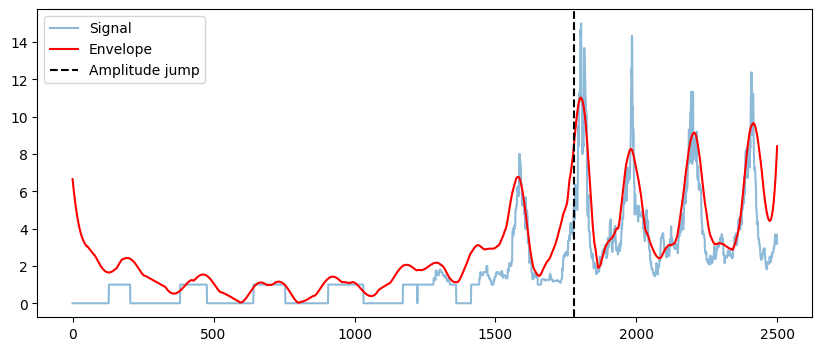

In [68]:
from scipy.signal import hilbert, savgol_filter
analytic_signal = hilbert(ratio[500:])
amplitude_envelope = np.abs(analytic_signal)

# Smooth envelope to remove ripple
envelope_smooth = savgol_filter(amplitude_envelope, 101, 3)
d_env = np.gradient(envelope_smooth)

# Threshold: mean + N * std
threshold = np.mean(d_env) + 3 * np.std(d_env)

change_index = np.argmax(d_env > threshold)
plt.figure(figsize=(10,4))
plt.plot(ratio[500:], alpha=0.5, label='Signal')
plt.plot(envelope_smooth, 'r', label='Envelope')
plt.axvline(change_index, color='k', linestyle='--', label='Amplitude jump')
plt.legend()
plt.show()

In [41]:
first_peak_index

np.int64(1981)

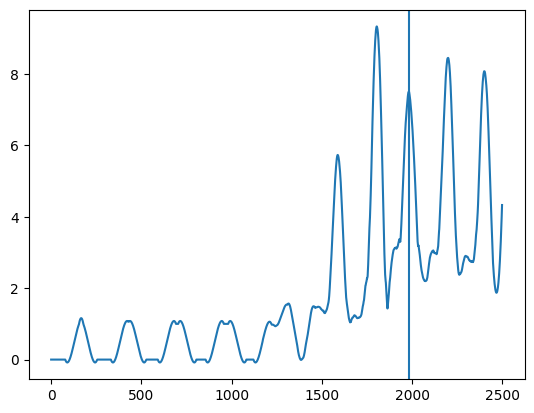

In [55]:
plt.plot(y_smooth)
plt.axvline(x=1981)

In [52]:
first_peak_index

np.int64(1805)

(0.0, 30.0)

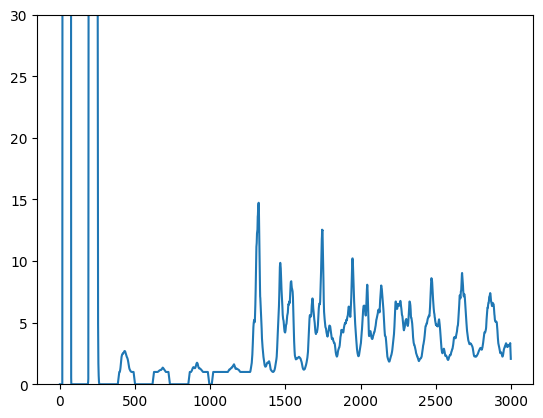

In [84]:
plt.plot(smooth_ratio)
# plt.plot(ratio)
plt.ylim(0,30)

In [57]:
def sliding_window_max(arr, window):
    temp = []
    for i in range(len(arr) - window + 1):
        temp.append([arr[i:i+window].min(), arr[i:i+window].max()])
    return temp

In [58]:
min_max = sliding_window_max(y_smooth, 10)

In [60]:
min_max = np.array(min_max)

In [65]:
for i in min_max:
    print(i)

[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.01413054  0.        ]
[-0.02681919  0.        ]
[-0.03809507  0.        ]
[-0.04798732  0.        ]
[-0.05652507  0.        ]
[-0.06373744  0.        ]
[-0.06965357  0.        ]
[-0.07430258  0.        ]
[-0.07771359  0.        ]
[-0.07991576 -0.01413054]
[-0.08093819 -0.02681919]
[-0.08093819 -0.03809507]
[-0.08093819 -0.04798732]
[-0.08093819 -0.05652507]
[-0.08093819 -0.06373744]
[-0.08093819 -0.06937393]
[-0.08093819 -0.06392969

In [11]:
def find_last_zero(arr):
    temp = 0
    for i in range(len(arr)):
        if arr[i] == 0:
            temp = i
    return temp

In [18]:
# could change to: if four of the last five are increasing
def find_first_peak(arr):
    last = 0
    for i in range(len(arr)):
        if arr[i] < last:
            return i
        else:
            last = arr[i]

In [138]:
smooth_test.shape

(4000,)

In [13]:
find_last_zero(sum_nine_zipper)

1278

In [35]:
test = sliding_window_max(sum_two_zipper[500:], 100)

In [20]:
find_first_peak(smooth_test[852:])

55

In [164]:
ratio[807]

tensor(0., dtype=torch.float64)

<Axes: >

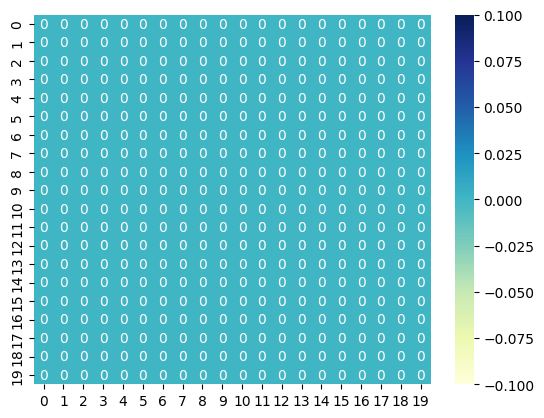

In [159]:
sns.heatmap(labels_nine_another_zipper[807], annot=True, cmap="YlGnBu")

<Axes: >

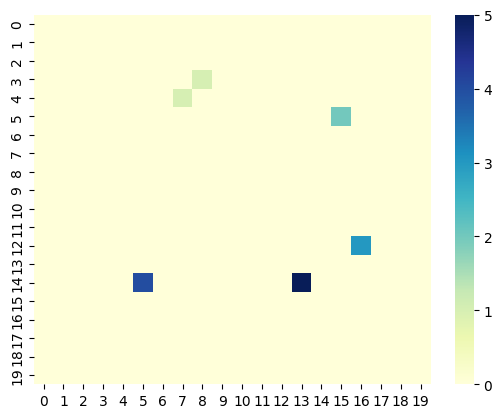

In [ ]:
sns.heatmap(labels_zero_another_zipper[1011+45], annot=False, cmap="YlGnBu")

<Axes: >

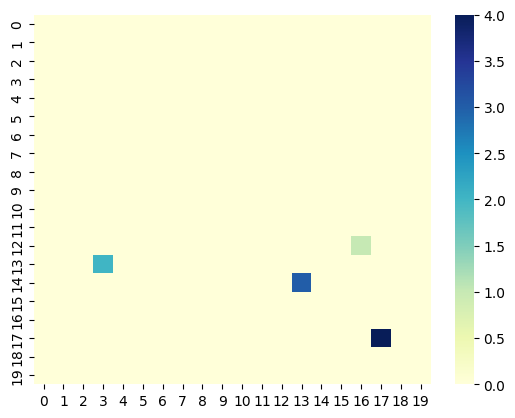

In [90]:
sns.heatmap(labels_zero_zipper[1008+44], annot=False, cmap="YlGnBu")

<Axes: >

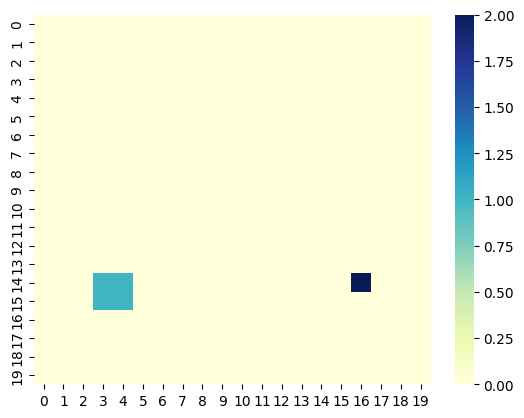

In [ ]:
sns.heatmap(labels_six_zipper[1662+46], annot=False, cmap="YlGnBu")
# plt.savefig("two.png")

<Axes: >

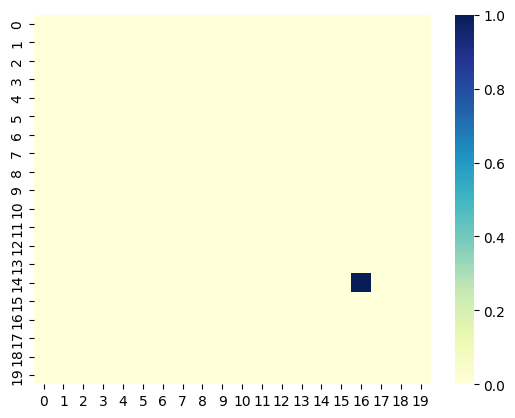

In [81]:
sns.heatmap(labels_nine_zipper[1669+45], annot=False, cmap="YlGnBu")

<Axes: >

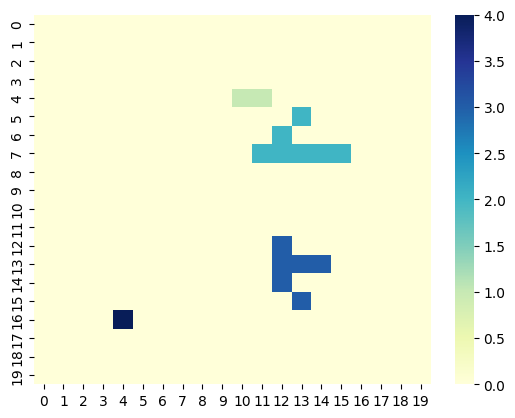

In [82]:
sns.heatmap(labels_two_zipper[1289+44], annot=False, cmap="YlGnBu")

In [48]:
sum_two_zipper[1289+44]

tensor(15.)

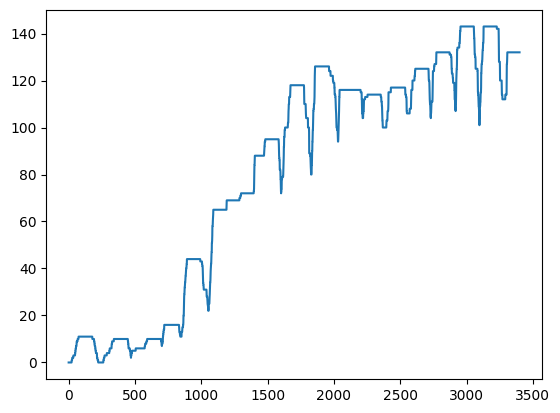

In [36]:
plt.plot(test)

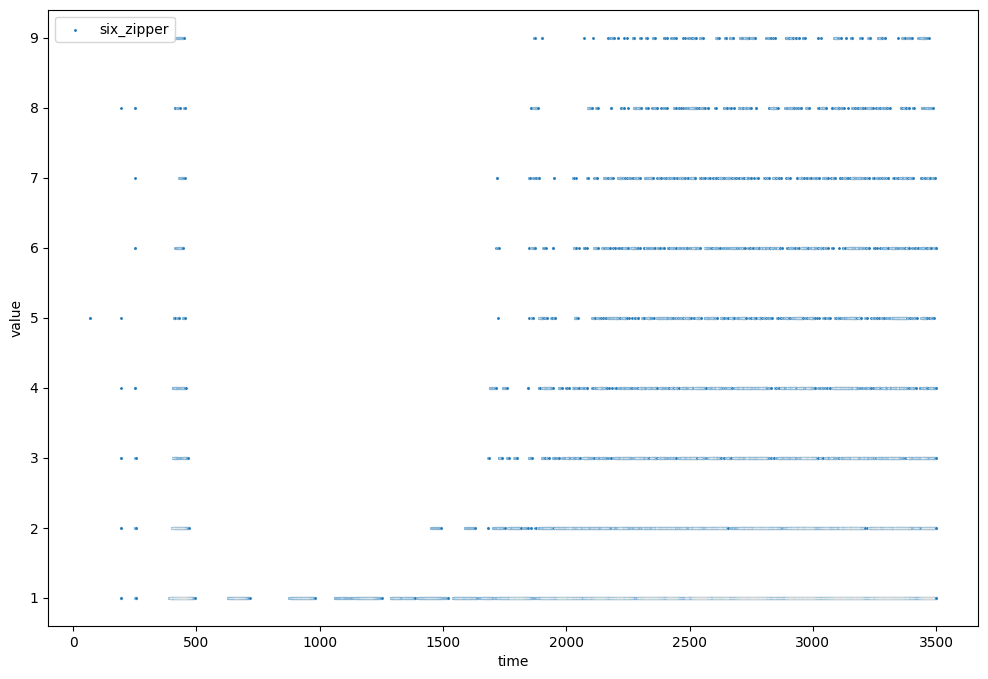

In [48]:
# df["time_num"] = pd.to_numeric(df["time"], errors="coerce")
fig, ax = plt.subplots(figsize=(12, 8))
# sns.scatterplot(data=df_six[:], x="time", y="value", ax=ax, s=5, label="six")
# sns.scatterplot(data=df_nine[:], x="time", y="value", ax=ax, s=5, label="nine")
# sns.scatterplot(data=df_zero[:], x="time", y="value", ax=ax, s=5, label="zero")
# sns.scatterplot(data=df_two[:], x="time", y="value", ax=ax, s=5, label="two")
# sns.scatterplot(data=df_seven[:], x="time", y="value", ax=ax, s=5, label="seven")
# sns.scatterplot(data=df_nine_zipper[:], x="time", y="value", ax=ax, s=5, label="nine_zipper")
sns.scatterplot(data=df_six_zipper[:], x="time", y="value", ax=ax, s=5, label="six_zipper")
ax.legend()
# ax.plot(times[500:], sum_six.cpu()[500:], label='same', lw=0.5)

In [51]:
labels_nine_zipper[950]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
cats = times.astype(str).unique()

In [ ]:
time_to_cat = 

Avalanches sizes and probabilities/counts

In [10]:
# not per time
total_sizes = []
for i in range(E_fires[500:].shape[0]):
    blob_sizes, temp = avalanches(E_fires[i])

    # limit sizes
    # blob_sizes = blob_sizes[blob_sizes>10]
    # blob_sizes = blob_sizes[blob_sizes<100]
    
    total_sizes = np.concatenate((total_sizes, blob_sizes))

In [25]:
new = []
for i in total_sizes:
    if i <= 100:
        new.append(i)

In [11]:
new = total_sizes

In [ ]:
unique_sizes, counts = np.unique(new, return_counts= True)
probs = counts/counts.sum()

In [23]:
unique_sizes

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,
        90.,  91.,  93.,  94.,  96.,  99., 100., 101., 112., 135., 152.,
       161., 194., 204., 243., 244., 255., 265., 303., 316., 320., 322.,
       326., 335., 364., 376., 386., 388., 389., 390., 396., 398., 399.,
       400.])

In [41]:
log_sizes = np.log(unique_sizes)
log_counts = np.log(counts)
log_probs = np.log(probs)

In [26]:
np.log(400)

np.float64(5.991464547107982)

In [42]:

df = pd.DataFrame({
    "log_size": log_sizes,
    # "log_count": log_counts,
    "log_probs": log_probs
})

In [43]:
from scipy.stats import linregress
res = linregress(df["log_size"], df["log_probs"])

In [33]:
intercept = res.intercept
slope = res.slope

In [35]:
from scipy.stats import pearsonr

In [ ]:
r,p = pearsonr(df["log_size"], df["log_count"])

In [46]:
r

np.float64(-0.9658011999759423)

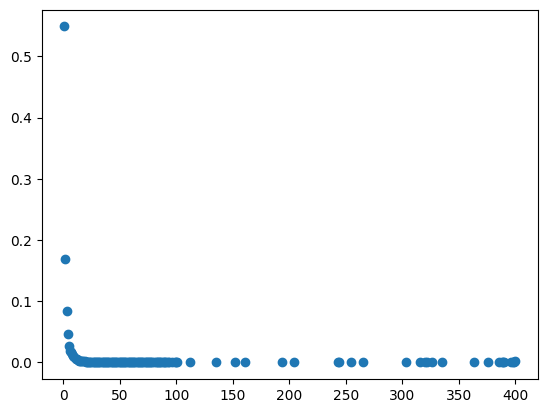

In [37]:
plt.plot(unique_sizes, probs, "o")
# plt.savefig("size_count.png", dpi=300, bbox_inches="tight")

In [102]:
log_sizes.min()

np.float64(2.3978952727983707)

In [44]:
res.slope

np.float64(-1.5193148239067806)

In [123]:
for i in probs:
    print(i)

0.13329141779314682
0.15969820811065702
0.09871109713926438
0.10154039610185477
0.07010374096196165
0.04306821754165357
0.03772398616787174
0.026092423766111286
0.030179188934297392
0.02986482238289846
0.028921722728701665
0.03740961961647281
0.017290160326941213
0.0191763596353348
0.013832128261552971
0.0069160641307764855
0.00817353033637221
0.010374096196164728
0.006287331027978623
0.004715498270983967
0.0044011317195850365
0.004086765168186105
0.005972964476579692
0.006287331027978623
0.0069160641307764855
0.009430996541967935
0.007544797233574348
0.00534423137378183
0.004086765168186105
0.006287331027978623
0.0028292989625903803
0.003772398616787174
0.002514932411191449
0.0028292989625903803
0.005029864822382898
0.004715498270983967
0.004086765168186105
0.004086765168186105
0.0028292989625903803
0.0012574662055957245
0.0009430996541967935
0.00031436655139893113
0.0022005658597925182
0.001886199308393587
0.0015718327569946558
0.0012574662055957245
0.0006287331027978623
0.0012574662

In [20]:
df

,log_size,log_probs
0,0.000000,-0.599807
1,0.693147,-1.772721
2,1.098612,-2.481691
3,1.386294,-3.054022
4,1.609438,-3.598699
...,...,...
117,5.966147,-10.270731
118,5.981414,-9.577584
119,5.986452,-10.270731
120,5.988961,-10.270731


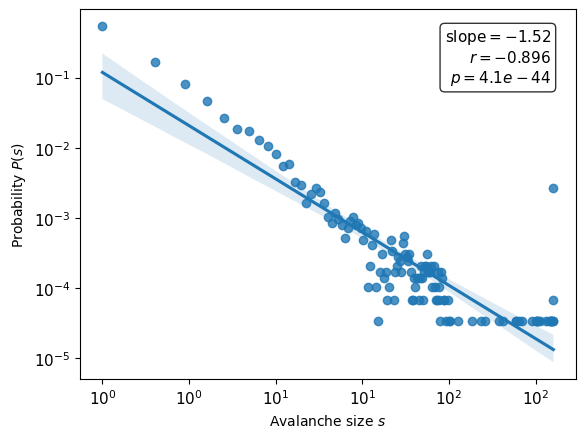

In [39]:
sns.regplot(data=df, y="log_probs", x="log_size")

# plt.scatter(unique_sizes, probs)
plt.xlabel("Avalanche size $s$")
plt.ylabel("Probability $P(s)$")

# plt.xlabel(r"$\log_{10}(Size)$", fontsize=11)
# plt.ylabel(r"$\log_{10} P(Size)$", fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

def log_format(x, pos):
    return f"$10^{{{int(np.log10(10**x))}}}$"
from matplotlib.ticker import FuncFormatter
# Apply formatter
plt.gca().xaxis.set_major_formatter(FuncFormatter(log_format))
plt.gca().yaxis.set_major_formatter(FuncFormatter(log_format))

plt.text(
    0.95, 0.95,   # near top-right
    rf"$\mathrm{{slope}} = {res.slope:.2f}$" "\n"
    rf"$r = {res.rvalue:.3f}$" "\n"
    rf"$p = {res.pvalue:.1e}$",
    transform=plt.gca().transAxes,
    fontsize=11,
    verticalalignment="top",    # aligns text top
    horizontalalignment="right", # aligns text right
        bbox=dict(
        boxstyle="round,pad=0.3",  # smooth corners with padding
        facecolor='white',          # optional fill color
        edgecolor='black',          # border color
        alpha=0.8                   # transparency
    )
)

# x_fit = np.logspace(np.log10(unique_sizes.min()), np.log10(unique_sizes.max()), 200)
# y_fit = (10**res.intercept) * (x_fit**res.slope)

# plt.plot(x_fit, y_fit, "--", label="Fit")

# plt.xscale("log")
# plt.yscale("log")
plt.savefig("log_log_reg.png", dpi=300, bbox_inches="tight")


In [ ]:
sns.histplot(new)
# plt.savefig("histo.png", dpi=300, bbox_inches="tight")

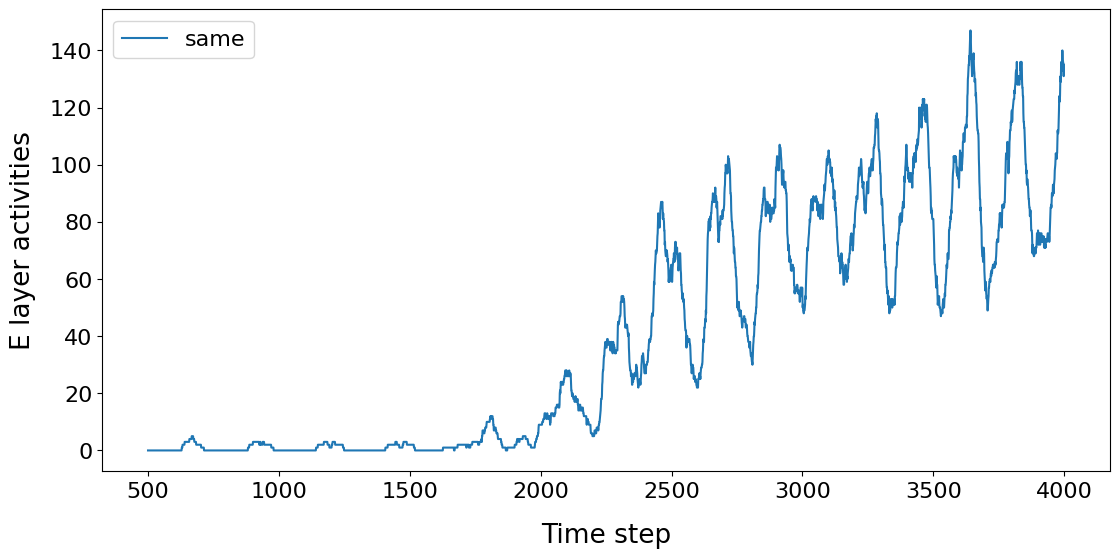

In [48]:
plt.figure(figsize=(13, 6))
font_size = 16

# plt.plot(times[500:], sum_six.cpu()[500:], label='Same')
plt.plot(times[500:], sum_nine.cpu()[500:], label='same')
# plt.plot(times[500:], sum_zero.cpu()[500:], label='Different')
# plt.plot(times[500:], sum_one.cpu()[500:], label='Different')
# plt.plot(times, sum_six.cpu()[500:])
plt.legend(fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.xlabel('Time step', fontsize=font_size+3, labelpad=15)
plt.ylabel('E layer activities', fontsize=font_size+3, labelpad=10)
plt.savefig('EEG.png', dpi=300, bbox_inches='tight')

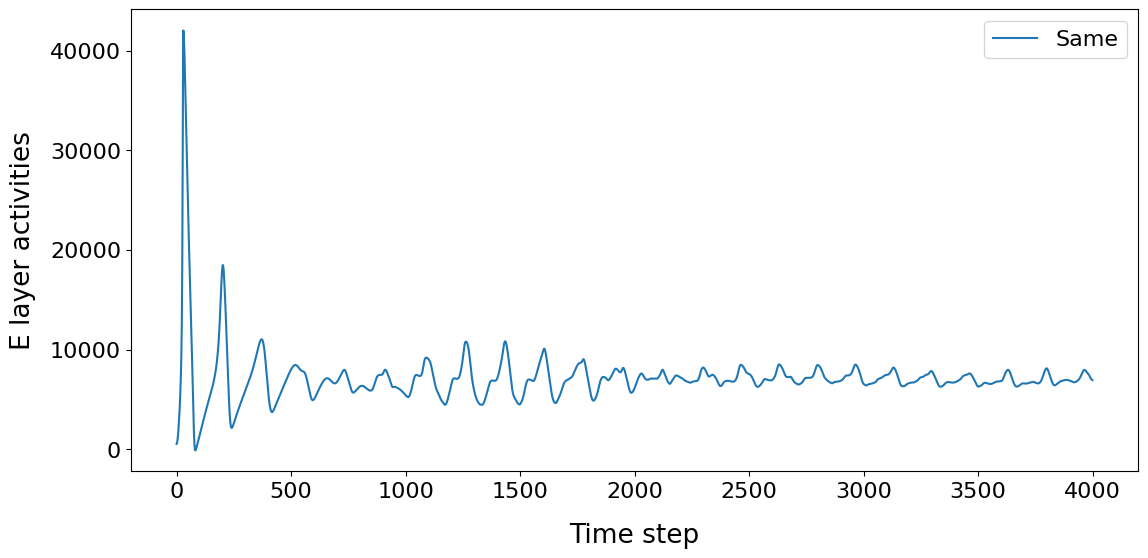

In [51]:

plt.figure(figsize=(13, 6))
font_size = 16

plt.plot(times[:], sum_six.cpu()[:], label='Same')
# plt.plot(times, sum_four.cpu()[500:], label='Different')
# plt.plot(times, sum_six.cpu()[500:])
plt.legend(fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.xlabel('Time step', fontsize=font_size+3, labelpad=15)
plt.ylabel('E layer activities', fontsize=font_size+3, labelpad=10)
plt.savefig('EEG.png', dpi=300, bbox_inches='tight')

In [119]:
size = 4
sum_E_fires = torch.zeros((4000,5,5))
for i in range(5):
    for j in range(5):
        sub_array = E_fires[:, i*size:i*size+size, j*size:j*size+size]
        temp_sum = sub_array.sum(dim=(1,2))
        sum_E_fires[:,i,j] = temp_sum

In [120]:
sum_E_fires.shape

torch.Size([4000, 5, 5])

<Axes: >

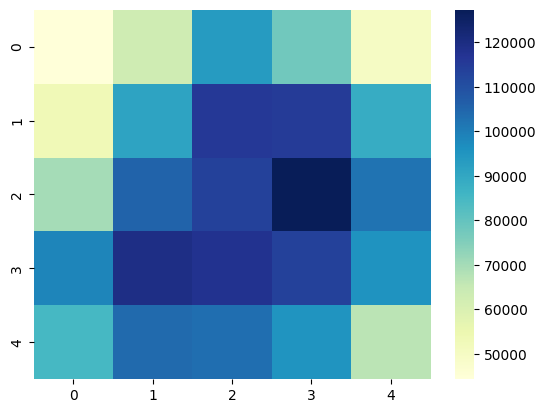

In [123]:

sns.heatmap(sum_E_fires[2000:2500].sum(dim=0).cpu(), annot=False, cmap="YlGnBu")

In [7]:
sum_nine_another = E_fires.sum(dim=(1,2)) 
# maxi = torch.max(sum[1000:1250])
# sum = sum[500:2000].sum()
# if sum > 2500:
#     print(sum)
#     print("nine")

In [19]:
test_out = Out_fires

In [20]:
test_out.shape

torch.Size([4000, 5, 5])

<Axes: >

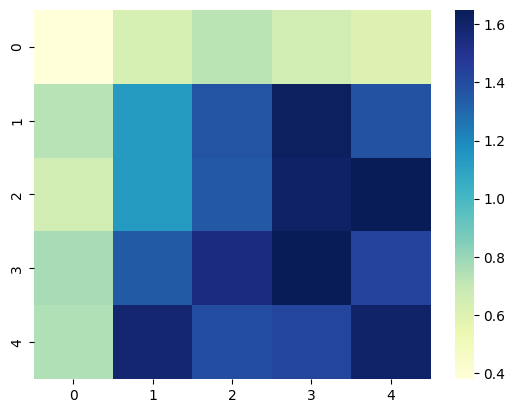

In [26]:
sns.heatmap(test_out[750].cpu(), annot=False, cmap="YlGnBu")

In [133]:
dict = {
    'nine': sum_nine_another,
    'four': sum_four
}

In [134]:
with open(path + "classi_4_9.pkl", "wb") as f:
    pickle.dump(dict, f)

In [3]:
with open(path + "classi_4_9.pkl", "rb") as f:
    EEGs = pickle.load(f)

In [4]:
EEGs

{'nine': tensor([  0.,   0.,   0.,  ..., 156., 165., 163.], device='cuda:0'),
 'four': tensor([  0.,   0.,   0.,  ..., 120., 120., 119.], device='cuda:0')}

In [12]:
# times = torch.arange(500, 4000)
times = torch.arange(0, 4000)

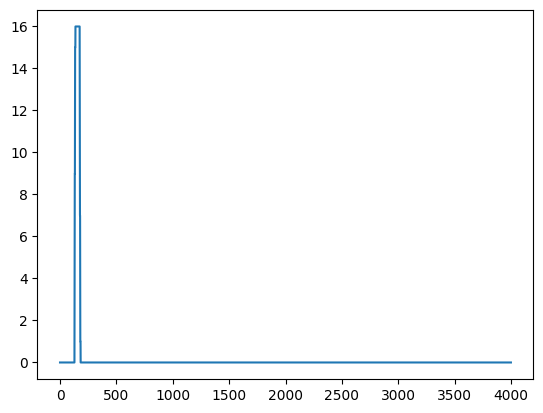

In [13]:
plt.plot(times, test_out.cpu(), label='Same')

In [6]:
sum_nine = EEGs['nine']
sum_four = EEGs['four']

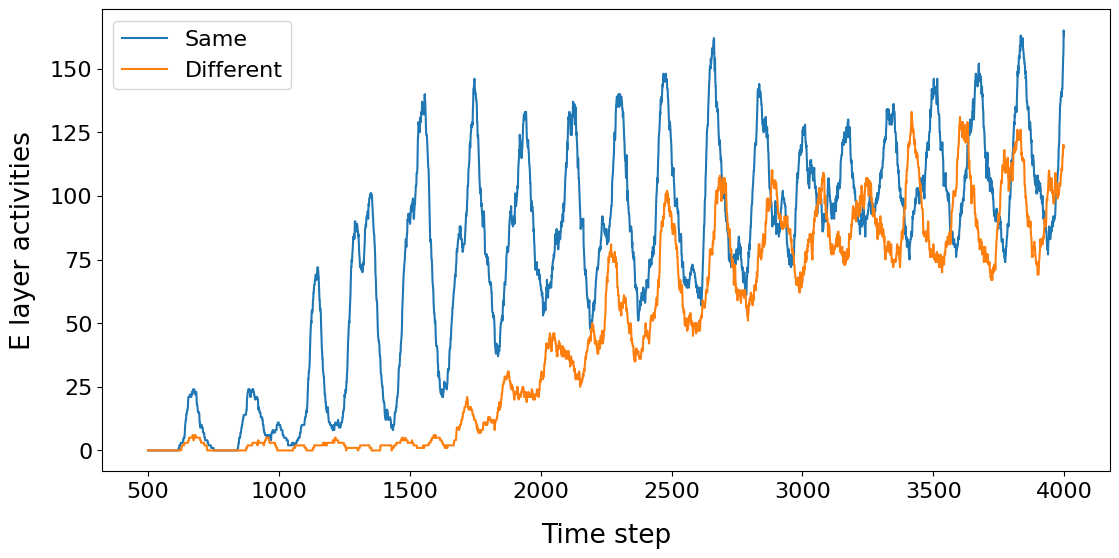

In [13]:

plt.figure(figsize=(13, 6))
font_size = 16

plt.plot(times, sum_nine.cpu()[500:], label='Same')
plt.plot(times, sum_four.cpu()[500:], label='Different')
# plt.plot(times, sum_six.cpu()[500:])
plt.legend(fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.xlabel('Time step', fontsize=font_size+3, labelpad=15)
plt.ylabel('E layer activities', fontsize=font_size+3, labelpad=10)
plt.savefig('EEG.png', dpi=300, bbox_inches='tight')

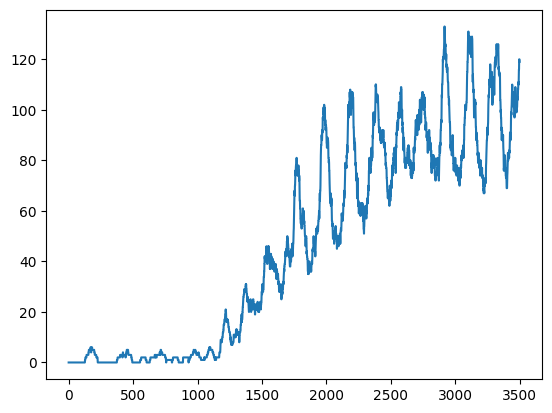

In [96]:
plt.plot(sum_four.cpu()[500:])

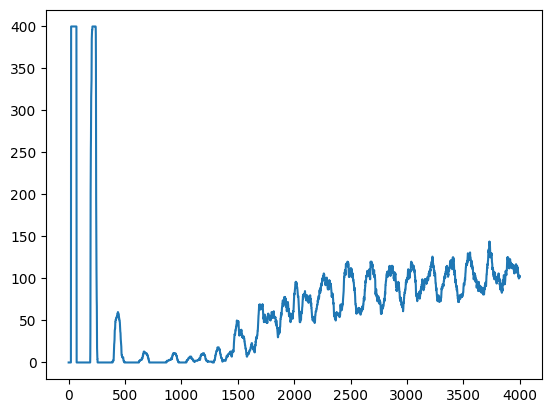

In [73]:
plt.plot(sum.cpu())

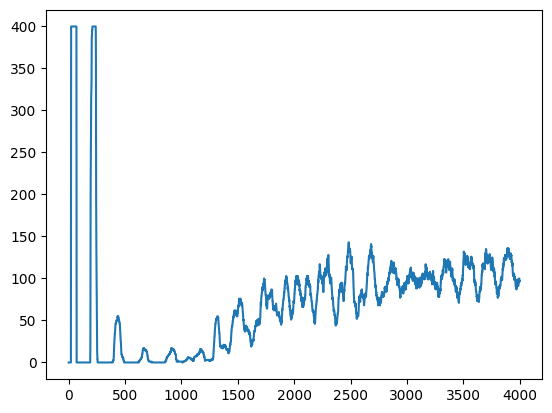

In [51]:
plt.plot(sum.cpu())

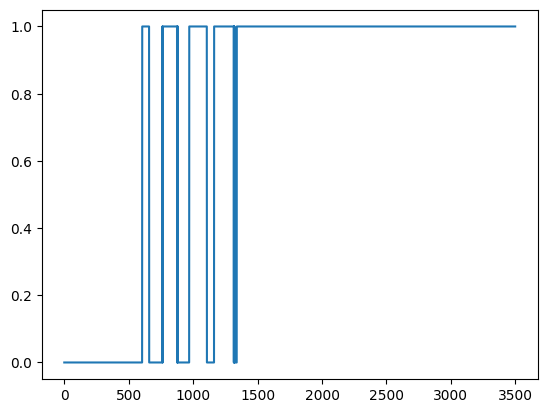

In [166]:
plt.plot(sum.cpu()[500:]>40)

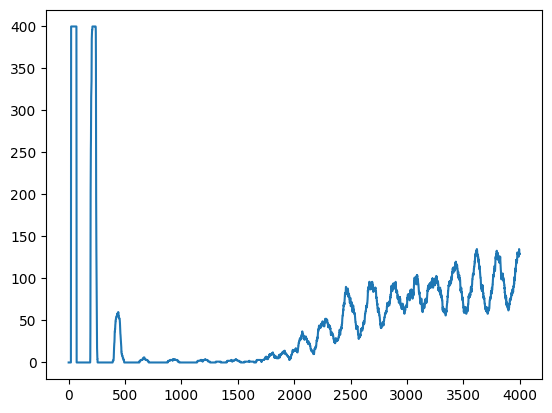

In [159]:
plt.plot(sum.cpu())

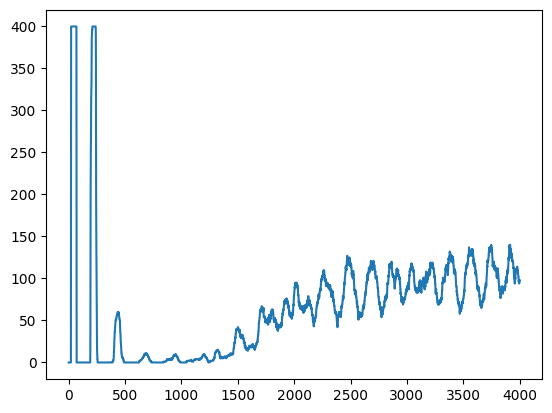

In [151]:
plt.plot(sum.cpu())

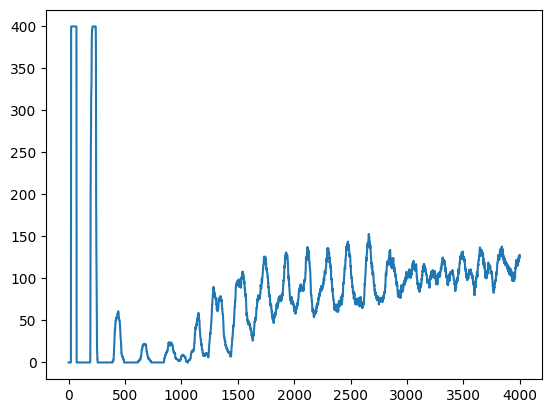

In [147]:
plt.plot(sum.cpu())

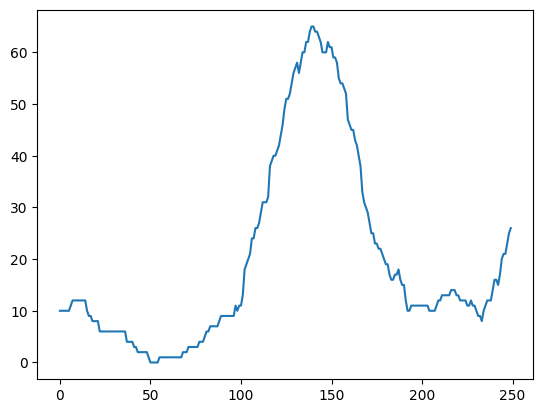

In [26]:
plt.plot(sum_nine_fourth[1000:1250])

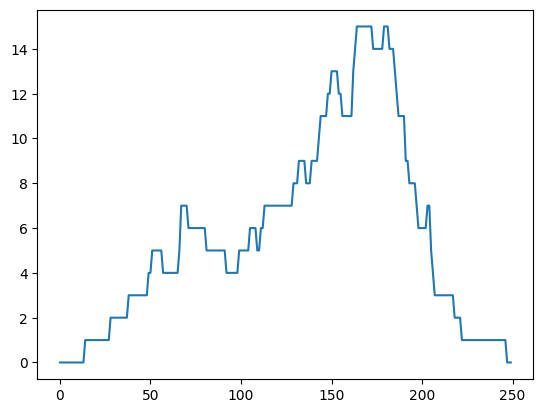

In [27]:
plt.plot(sum_zero[1000:1250])

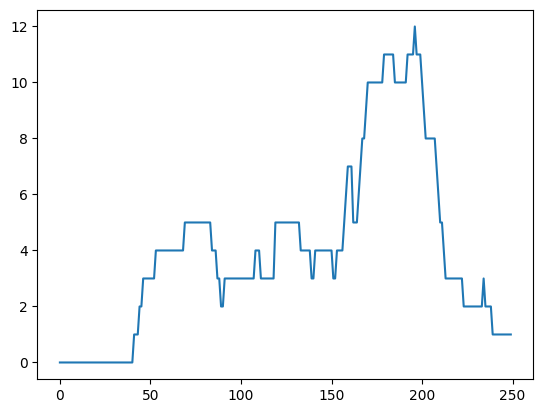

In [28]:
plt.plot(sum_one[1000:1250])

In [ ]:
sum_zero = E_fires[:].sum(dim=(1,2)).cpu()

In [ ]:
sum_one = E_fires[:].sum(dim=(1,2)).cpu()

In [ ]:
sum_nine_fourth = E_fires[:].sum(dim=(1,2)).cpu()

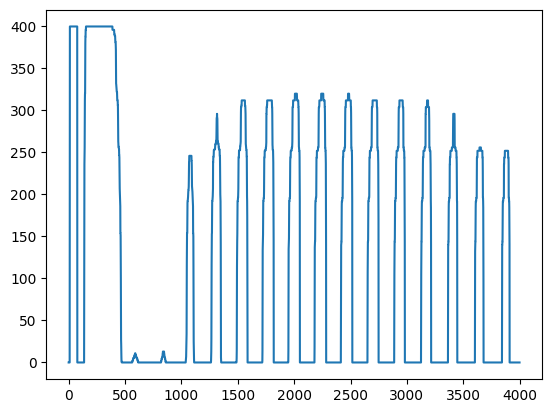

In [109]:
plt.plot(sum.cpu())

<Axes: >

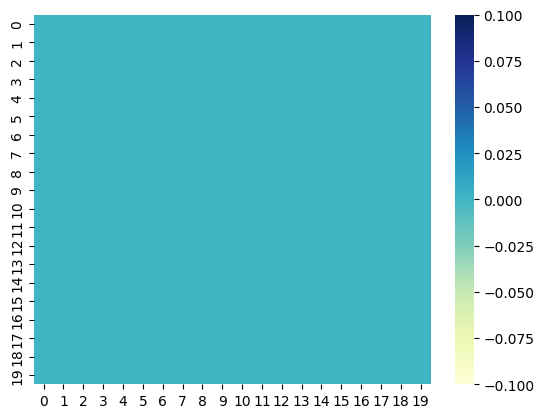

In [100]:
import seaborn as sns
sns.heatmap(fires[1020].cpu(), annot=False, cmap="YlGnBu")